# AI Detection System

In [21]:
import gc
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast


import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoConfig
import joblib
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig
warnings.filterwarnings("ignore")


from PIL import Image 
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score


import sklearn
import librosa
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings


warnings.filterwarnings("ignore")

# TEXT 
#### Approach: TF-IDF

In [ ]:
df_pl = pl.read_parquet("//home/rijkaa/leraa/train_essays.parquet")#-----------------------------------------------------------------------------------------------
df_pl = df_pl.unique(subset=['text'], maintain_order=True)
train, test = train_test_split(df_pl, train_size=0.9, random_state=42)

VOCAB_SIZE = 30522

# Выбор токенизатора, пре-токенизатора и нормализатора (предобработка)
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

dataset = pl.DataFrame({"text": test['text']})

# Обучение токенизатора
def train_corp_iter():
  for i in range(0, len(dataset), 1000):
    yield dataset[i: i + 1000]["text"]
    
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=raw_tokenizer,
        unk_token="[UNK]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        sep_token="[SEP]",
        mask_token="[MASK]",
    )

# Токенизация текстов
tokenized_texts_test = []
for text in tqdm(test['text'].to_list()):
    tokenized_texts_test.append(tokenizer.tokenize(text))
    
tokenized_texts_train = []
for text in tqdm(train['text'].to_list()):
    tokenized_texts_train.append(tokenizer.tokenize(text))
    
def dummy(text):
        return text
    
del tokenizer, raw_tokenizer, df_pl, trainer, test, train, dataset 

# Здесь формируется TF-IDF матрица из проверяемых (тестовых) текстов. При этом знание о классе не используется 
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer='word',
                             tokenizer=dummy, preprocessor=dummy,
                             token_pattern=None, strip_accents='unicode')

vectorizer.fit(tokenized_texts_test)

# Запоминаем словарь, который получили из тестовых текстов
vocab = vectorizer.vocabulary_

# По этому словарю раскладываем train множество 
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                             analyzer='word', tokenizer=dummy, preprocessor=dummy,
                             token_pattern=None, strip_accents='unicode')

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)
del vocab, vectorizer, tokenized_texts_train, tokenized_texts_test
gc.collect()

df_pl = pl.read_parquet("//home/rijkaa/leraa/train_essays.parquet")#-----------------------------------------------------------------------------------------------
df_pl = df_pl.unique(subset=['text'], maintain_order=True)
train, test = train_test_split(df_pl, train_size=0.9, random_state=42)

# Достаем информацию о классе элементов в train 
y_train = train.get_column('generated').to_numpy()

# определяем модели для классификации 
clf = MultinomialNB(alpha=0.02)
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber", class_weight='balanced')
"""p6 = {
    'n_iter': 2500,
    'num_leaves': 51,
    'objective': 'cross_entropy',
    'metric': 'auc',
    'learning_rate': 0.05,
    'colsample_bytree': 0.726,
    'colsample_bynode': 0.5803,
    'lambda_l1': 8.5629,
    'num_threads': 4,
    'lambda_l2': 4.8932,
    'min_data_in_leaf': 115,
    'max_depth': 23,
    'max_bin': 898
}

lgb = LGBMClassifier(**p6)"""

# Обучаем модели и предсказываем результат 
clf.fit(tf_train, y_train)
p1 = clf.predict_proba(tf_test)[:, 1]
print("NB Done!")

sgd_model.fit(tf_train, y_train)
p2 = sgd_model.predict_proba(tf_test)[:, 1]
print("SGD Done!")

"""lgb.fit(tf_train, y_train)
p3 = lgb.predict_proba(tf_test)[:, 1]
print("LGBM Done!")
"""
del clf, sgd_model
gc.collect()

# Формируем финальный результат 
final_preds = p1*0.2 + p2*0.8     # p1*0.1 + p2*0.45 + p3*0.45
final_preds

final_preds = np.array(final_preds)

# Выбираем threshold для бинарной классификации 
threshold = 0.43  # 0.4 (0.8798106606297592 & 0.7875204657085683)    0.5 (0.9054815026017535 & 0.8391850100054575)     0.6 (0.9278292388240033 & 0.8913346673943363)
class_preds = []
class_preds = [1 if i > threshold else 0 for i in final_preds]

# Считаем метрики --- метрики в ноутбуке text_base_solution 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score, fbeta_score

 # учитывают дисбаланс классов 
print(f1_score(test.get_column('generated').to_numpy(), class_preds, average='weighted')) 
print(fbeta_score(test.get_column('generated').to_numpy(), class_preds, average='weighted', beta=2))
print(balanced_accuracy_score(test.get_column('generated').to_numpy(), class_preds))
print(roc_auc_score(test.get_column('generated').to_numpy(), class_preds, average = 'weighted'))

# не учитывают
print(accuracy_score(test.get_column('generated').to_numpy(), class_preds))
print(roc_auc_score(test.get_column('generated').to_numpy(), class_preds))


#### Approach: LLM

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np

In [33]:
def evaluation_llm(file_path=None, string=None):
    tokenizer = AutoTokenizer.from_pretrained('/home/rijkaa/leraa/solution/deberta-xsmall-finetuned/checkpoint-14484')
    model = AutoModelForSequenceClassification.from_pretrained('/home/rijkaa/leraa/solution/deberta-xsmall-finetuned/checkpoint-14484/')
    trainer_args = TrainingArguments(
        'tmp_trainer',
        per_device_eval_batch_size=4,
    )
    trainer = Trainer(
        model,
        trainer_args,
        tokenizer=tokenizer
    )
    def preprocess_function(example):
        return tokenizer(example['text'], max_length=128, padding=True, truncation=True)
    if file_path is not None:
        with open(file_path) as file:
            string = file.read()
    
    if string is not None:
        data = Dataset.from_dict({'text':[string]})
        tokenized_data = data.map(preprocess_function, batched=True)
        logits = trainer.predict(tokenized_data).predictions
        probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        # print(probs[0, 1])
        if probs[0, 1] > 0.5:
            print('Generated')
        else:
            print('Natural')
    
    torch.cuda.empty_cache()
    gc.collect()

In [34]:
string = 'And yet, as the members severally shook their heads and confessed defeat at the Inspector’s problem, there was one man in that gathering who suspected a touch of bizarre familiarity in the monstrous shape and writing, and who presently told with some diffidence of the odd trifle he knew. This person was the late William Channing Webb, Professor of Anthropology in Princeton University, and an explorer of no slight note. Professor Webb had been engaged, forty-eight years before, in a tour of Greenland and Iceland in search of some Runic inscriptions which he failed to unearth; and whilst high up on the West Greenland coast had encountered a singular tribe or cult of degenerate Esquimaux whose religion, a curious form of devil-worship, chilled him with its deliberate bloodthirstiness and repulsiveness. It was a faith of which other Esquimaux knew little, and which they mentioned only with shudders, saying that it had come down from horribly ancient aeons before ever the world was made. Besides nameless rites and human sacrifices there were certain queer hereditary rituals addressed to a supreme elder devil or tornasuk; and of this Professor Webb had taken a careful phonetic copy from an aged angekok or wizard-priest, expressing the sounds in Roman letters as best he knew how. But just now of prime significance was the fetish which this cult had cherished, and around which they danced when the aurora leaped high over the ice cliffs. It was, the professor stated, a very crude bas-relief of stone, comprising a hideous picture and some cryptic writing. And so far as he could tell, it was a rough parallel in all essential features of the bestial thing now lying before the meeting.'
evaluation_llm(string=string) # https://www.hplovecraft.com/writings/texts/fiction/cc.aspx The Call of Cthulhu By H. P. Lovecraft

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Natural


In [35]:
string = "The old bookstore stood at the corner of Elm Street, its weathered facade a testament to the passage of time. Inside, shelves sagged under the weight of countless volumes, each one a portal to another world, another time. Amelia traced her fingers along the spines, feeling the whisper of history beneath her touch. The scent of aging paper hung in the air, mingling with the faint aroma of coffee from the corner cafe. It was a sanctuary of words, a refuge from the chaos of the outside world. As she wandered through the aisles, she stumbled upon a dusty tome tucked away in a forgotten corner. Its leather-bound cover was embossed with intricate designs, and its pages yellowed with age. Curiosity piqued, she gently lifted it from the shelf, cradling it in her hands as if holding a precious treasure. Opening the book, she was transported to a world of magic and mystery, where dragons soared across the skies and heroes embarked on epic quests. With each turn of the page, she felt herself drawn deeper into the story, losing herself in its enchanting embrace. Time seemed to stand still as she devoured the words, the outside world fading away until there was only her and the book. And in that moment, she realized the true magic of literature — the power to transport, to transform, to ignite the imagination and stir the soul."
evaluation_llm(string=string)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Generated


In [37]:
evaluation_llm(string="Hello everyone! My name is Lera and I'd like to welcome you on my presentation")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Generated


# CV
#### Approach: RESNet

In [44]:
# Определяем предобработку файла 
class CustomDataset(Dataset):

    def __init__(self, path):
        self.path = path
          
    def __getitem__(self, idx):
        img = np.array(Image.open(self.path).resize((224, 224)), dtype='uint8')
        
        
        T = v2.Compose(
            [#transforms.ToTensor(),
             v2.ToImage(),
             v2.ToDtype(torch.uint8, scale=True),
             v2.Resize((224, 224), antialias=True),
             v2.ToDtype(torch.float32, scale=True),
             v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ] 
        )

        img = T(img)
        
        return {'image': img}
               
    def __len__(self):
        return 1
    

def evaluation_cv(img_path):  
    test = CustomDataset(img_path)      # используем предобработку файла 

    test_dataloader = DataLoader(test, batch_size=1)    # загружаем данные для использования нейронной сетью

    # определяем и загружаем модель 
    resnet = torchvision.models.resnet18()
    resnet.fc = torch.nn.Linear(in_features= 512, out_features=2, bias=True)
    checkpoint = torch.load('/home/rijkaa/leraa/solution/best_model_artifact_250000.pt') # путь к чекпоинту 
    for key in list(checkpoint.keys()):
        if key.startswith('module.'):
            checkpoint[key[7:]] = checkpoint.pop(key)
    
    resnet.load_state_dict(checkpoint)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    resnet.to(device)
    
    # используем модель 
    resnet.eval()
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            img = data["image"].cuda()
            prediction = resnet(img).argmax(dim = 1).cpu().detach().numpy()
            
            if prediction[0] > 0.5:     # выводим прогноз модели
                print('Generated')
            else:
                print('Natural')
            


    torch.cuda.empty_cache()
    gc.collect()

# AUDIO
#### Approach: RandomForestClassifier

In [2]:
# Feature extraction 
def test_data(path_audio):
    dataset = pl.DataFrame({"path": path_audio})
    dataset = dataset.with_columns([
        (pl.Series([0.1]).alias("zero_crossing_rate")),
        (pl.Series([0.1]).alias("zero_crossings")),
        (pl.Series([0.1]).alias("spectrogram")),
        (pl.Series([0.1]).alias("mel_spectrogram")),
        (pl.Series([0.1]).alias("harmonics")),
        (pl.Series([0.1]).alias("perceptual_shock_wave")),
        (pl.Series([0.1]).alias("spectral_centroids")),
        (pl.Series([0.1]).alias("spectral_centroids_delta")),
        (pl.Series([0.1]).alias("spectral_centroids_accelerate")),
        (pl.Series([0.1]).alias("chroma1")),
        (pl.Series([0.1]).alias("chroma2")),
        (pl.Series([0.1]).alias("chroma3")),
        (pl.Series([0.1]).alias("chroma4")),
        (pl.Series([0.1]).alias("chroma5")),
        (pl.Series([0.1]).alias("chroma6")),
        (pl.Series([0.1]).alias("chroma7")),
        (pl.Series([0.1]).alias("chroma8")),
        (pl.Series([0.1]).alias("chroma9")),
        (pl.Series([0.1]).alias("chroma10")),
        (pl.Series([0.1]).alias("chroma11")),
        (pl.Series([0.1]).alias("chroma12")),
        (pl.Series([0.1]).alias("tempo_bpm")),
        (pl.Series([0.1]).alias("spectral_rolloff")),
        (pl.Series([0.1]).alias("spectral_flux")),
        (pl.Series([0.1]).alias("spectral_bandwidth_2")),
        (pl.Series([0.1]).alias("spectral_bandwidth_3")),
        (pl.Series([0.1]).alias("spectral_bandwidth_4")),
    ])
    for i in tqdm(range(len(dataset))):
        audio_path = dataset[i, 0]

        y, sr = librosa.load(audio_path)

        signal = librosa.effects.trim(y)[0]

        d_audio = np.abs(librosa.stft(signal, n_fft=512)) # рекомендованное значение https://librosa.org/doc/main/generated/librosa.stft.html
        db_audio = librosa.amplitude_to_db(d_audio, ref=np.max)

        s_audio = librosa.feature.melspectrogram(y = signal, sr=sr)
        s_db_audio = librosa.amplitude_to_db(s_audio, ref=np.max)

        y_harm, y_perc = librosa.effects.hpss(signal)

        spectral_centroids = librosa.feature.spectral_centroid(y = signal, sr=sr)[0]
        spectral_centroids_delta = librosa.feature.delta(spectral_centroids)
        spectral_centroids_accelerate = librosa.feature.delta(spectral_centroids, order=2)

        chromagram = librosa.feature.chroma_stft(y = signal, sr=sr)

        tempo_y = librosa.beat.beat_track(y = signal, sr=sr)[0]

        spectral_rolloff = librosa.feature.spectral_rolloff(y = signal, sr=sr)[0]

        onset_env = librosa.onset.onset_strength(y=signal, sr=sr)

        spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y = signal, sr=sr)[0]
        spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y = signal, sr=sr, p=3)[0]
        spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y = signal, sr=sr, p=4)[0]

        dataset[i, "zero_crossing_rate"] = np.mean(librosa.feature.zero_crossing_rate(signal)[0])
        dataset[i, "zero_crossings"] = np.sum(librosa.zero_crossings(signal, pad=False))
        dataset[i, "spectrogram"] = np.mean(db_audio[0])
        dataset[i, "mel_spectrogram"] = np.mean(s_db_audio[0])
        dataset[i, "harmonics"] = np.mean(y_harm)
        dataset[i, "perceptual_shock_wave"] = np.mean(y_perc)
        dataset[i, "spectral_centroids"] = np.mean(spectral_centroids)
        dataset[i, "spectral_centroids_delta"] = np.mean(spectral_centroids_delta)
        dataset[i, "spectral_centroids_accelerate"] = np.mean(spectral_centroids_accelerate)
        dataset[i, "chroma1"] = np.mean(chromagram[0])
        dataset[i, "chroma2"] = np.mean(chromagram[1])
        dataset[i, "chroma3"] = np.mean(chromagram[2])
        dataset[i, "chroma4"] = np.mean(chromagram[3])
        dataset[i, "chroma5"] = np.mean(chromagram[4])
        dataset[i, "chroma6"] = np.mean(chromagram[5])
        dataset[i, "chroma7"] = np.mean(chromagram[6])
        dataset[i, "chroma8"] = np.mean(chromagram[7])
        dataset[i, "chroma9"] = np.mean(chromagram[8])
        dataset[i, "chroma10"]  = np.mean(chromagram[9])
        dataset[i, "chroma11"] = np.mean(chromagram[10])
        dataset[i, "chroma12"] = np.mean(chromagram[11])
        dataset[i, "tempo_bpm"] = tempo_y
        dataset[i, "spectral_rolloff"] = np.mean(spectral_rolloff)
        dataset[i, "spectral_flux"] = np.mean(onset_env)
        dataset[i, "spectral_bandwidth_2"] = np.mean(spectral_bandwidth_2)
        dataset[i, "spectral_bandwidth_3"] = np.mean(spectral_bandwidth_3)
        dataset[i, "spectral_bandwidth_4"] = np.mean(spectral_bandwidth_4)
    return dataset


def evaluation_audio(path_audio):
    data = test_data(path_audio) # извлечение фичей
    
    loaded_model = joblib.load("/home/rijkaa/leraa/solution/random_forest.joblib")      # загрузка модели 
    X_val = data[:, 1:]
    prediction = loaded_model.predict(X_val)    # презсказание класса
    if prediction[0] > 0.5:
        print('Generated')
    else:
        print('Natural')
    
    torch.cuda.empty_cache()
    gc.collect()
    

# path_audio = "/lll/ddd.wav"
# evaluation_audio(path_audio)


# Zapusk

In [16]:
from evaluation.llm import evaluation_llm
from evaluation.cv import evaluation_cv
from evaluation.audio import evaluation_audio
import os
import warnings
warnings.filterwarnings("ignore")
# конфликт импортов (например, Dataset из torch и Dataset из datasets)

In [17]:
def domen_define(file_path):
    file_extension = os.path.splitext(file_path)[-1].lower()
    if file_extension in ['.txt']:
        evaluation_llm(file_path)
    elif file_extension in ['.jpg', '.jpeg', '.png']:
        evaluation_cv(file_path)
    elif file_extension in ['.flac', '.wav', '.mp3']:
        evaluation_audio(file_path)
    else:
        print("Данный формат файла не поддерживается")

In [18]:
file_path = '/home/rijkaa/leraa/solution/cthulhu.txt'
domen_define(file_path)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Natural


In [11]:
from IPython.display import Audio

file_path = "/home/rijkaa/leraa/solution/ElevenLabs_2024-04-08T15_06_18_Grace.mp3"
Audio(file_path)

In [4]:
domen_define(file_path) # правильно определила

  0%|          | 0/1 [00:00<?, ?it/s]

Generated


In [13]:
file_path = "/home/rijkaa/leraa/solution/audio_2024-04-19_14-10-31.wav"
Audio(file_path)

In [14]:
domen_define(file_path) # правильно определила

  0%|          | 0/1 [00:00<?, ?it/s]

Natural


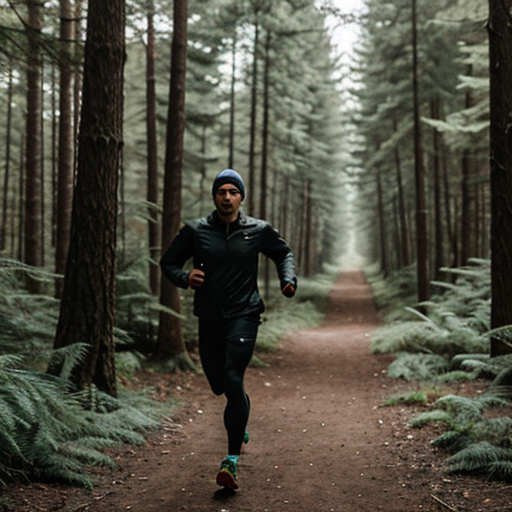

In [7]:
from IPython.display import Image
file_path = "/home/rijkaa/leraa/solution/The_man_who_runs_in_the_forest_2957499861.png"
Image(filename=file_path)

In [8]:
domen_define(file_path) # неправильно определила

  0%|          | 0/1 [00:00<?, ?it/s]

Natural


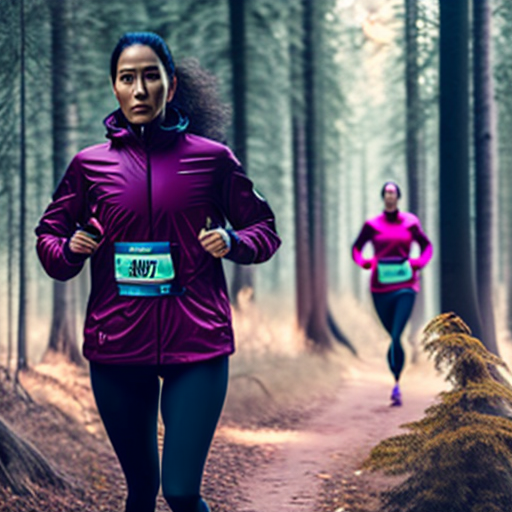

In [9]:
from IPython.display import Image
file_path = "/home/rijkaa/leraa/solution/estilovintedois_The_women_who_runs_in_the_forest_1990911196.png"
Image(filename=file_path)

In [10]:
domen_define(file_path) # правильно определила

  0%|          | 0/1 [00:00<?, ?it/s]

Generated


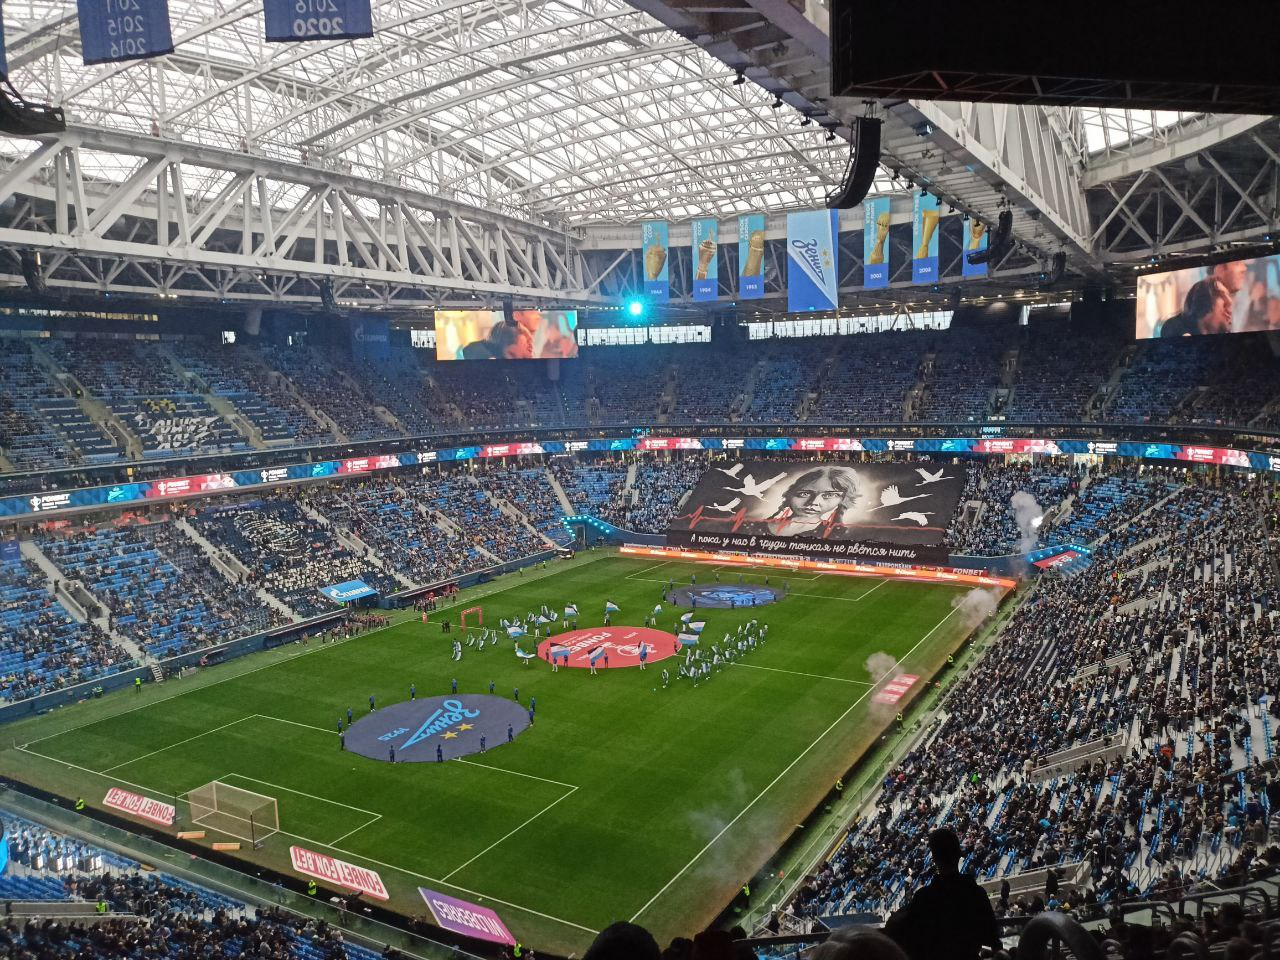

In [19]:
file_path = "/home/rijkaa/leraa/solution/photo_2024-04-18_15-47-19.jpg"
Image(file_path)

In [20]:
domen_define(file_path) # правильно определила

  0%|          | 0/1 [00:00<?, ?it/s]

Natural
